### Import Statements

In [200]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from holoviews.plotting.bokeh.styles import font_size
from numba.np.npdatetime import add_constant

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB


## 1. Time Series Classification Part 1: Feature Creation/Extraction


This is 1st part of time series which has data loading, preprocessing → splitting the time series into multiple time series, feature extraction and creating a feature vector for each instance and then creating a dataframe from the extracted features.
* i. Load the dataset and create a time series for each instance. Each time series consists of 6 time series (one for each sensor).
* ii. Plot the time series for each instance and sensor.
* iii. Compute the time-domain features for each time series (mean, median, standard deviation, 1st quartile, 3rd quartile, min, max).
* iv. Create a feature vector for each instance by combining the features from the 6 time series. The feature vector should include the features from time series 1, 2, and 6.

In [51]:
# Load the dataset
# Similar to what was done in HW3, we will define a function to load a dataset file from the specified folder.
def load_dataset(folder_name, dataset_number, skip_rows=4):
    """Load a dataset file from the specified folder."""
    path = f'../data/ARem/{folder_name}/dataset{dataset_number}.csv'
    return pd.read_csv(path, skiprows=skip_rows)

def process_folder(folder_name, config, is_test=False):
    """Process all CSV files in a folder."""
    folder_features = []
    start = 1 if is_test else config['test'] + 1
    end = config['test'] if is_test else config['total']

    for i in range(start, end + 1):
        df = load_dataset(folder_name, i)
        features = extract_features(df, 'bending' if folder_name.startswith('bending') else 'other')
        folder_features.append(features)

    return folder_features

In [ ]:
# Extract the features from a DataFrame by splitting it into 6 time series
def extract_features(df, activity_label):
    """Extract features from a DataFrame and include the activity label."""
    series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
    features = {'activity': activity_label}

    for col in series:
        stats = df[col].describe()
        features[col] = {
            'min': stats['min'],
            'max': stats['max'],
            'mean': stats['mean'],
            'median': stats['50%'],
            'std dev': stats['std'],
            '1st quartile': stats['25%'],
            '3rd quartile': stats['75%']
        }

    return features

def create_feature_df(all_features):
    """Create a DataFrame from all extracted features."""
    rows = []
    instance_count = 1

    for folder_features in all_features:
        for instance_features in folder_features:
            row = [instance_count, instance_features.pop('activity')]
            for series in instance_features.values():
                row.extend(series.values())
            rows.append(row)
            instance_count += 1

    columns = ['Instance', 'activity']
    for i in range(1, 7):
        for feat in ['min', 'max', 'mean', 'median', 'std dev', '1st quartile', '3rd quartile']:
            columns.append(f'{feat}_{i}')

    return pd.DataFrame(rows, columns=columns)

def generate_datasets(folders_config, is_test=False):
    """Generate datasets for multiple folders."""
    features = [process_folder(folder, config, is_test) for folder, config in folders_config.items()]
    return create_feature_df(features)

# Define the folders and their respective dataset configurations
folders_config = {
    # For the folders bending1 and bending2, we will use datasets 1 and 2 as test data
    "bending1": {
        "total": 7,  # Number of datasets in the folder
        "test": 2  # Number of datasets to use as test data
    },
    "bending2": {
        "total": 6,
        "test": 2
    },

    # For the remaining folders, we will use datasets 1, 2, and 3 as test data
    "cycling": {
        "total": 15,
        "test": 3
    },
    "lying": {
        "total": 15,
        "test": 3
    },
    "sitting": {
        "total": 15,
        "test": 3
    },
    "standing": {
        "total": 15,
        "test": 3
    },
    "walking": {
        "total": 15,
        "test": 3
    },
}


In [52]:
# Generate test and train datasets
test_df = generate_datasets(folders_config, is_test=True)
train_df = generate_datasets(folders_config, is_test=False)

print("Test DataFrame shape:", test_df.shape)
print("Train DataFrame shape:", train_df.shape)

Test DataFrame shape: (19, 44)
Train DataFrame shape: (69, 44)


In [53]:
train_df.head()

,Instance,activity,min_1,max_1,mean_1,median_1,std dev_1,1st quartile_1,3rd quartile_1,min_2,...,std dev_5,1st quartile_5,3rd quartile_5,min_6,max_6,mean_6,median_6,std dev_6,1st quartile_6,3rd quartile_6
0,1,bending,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94
1,2,bending,33.00,47.75,42.179812,43.50,3.670666,39.15,45.00,0.0,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00
2,3,bending,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50
3,4,bending,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87
4,5,bending,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,...,3.318301,20.5000,23.75,0.0,2.96,0.555312,0.49,0.487826,0.00,0.83


In [83]:
train_df.shape, test_df.shape

((69, 45), (19, 44))

## 4. Time Series Classification Part 2: Classification
Assume that you want to use the training set to classify bending from other
activities, i.e. you have a binary classification problem. Depict scatter plots
of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of
each instance, and use color to distinguish bending vs. other activities. 

### (a) Binary Classification Using Logistic Regression
- I will use mean,median and standard deviation as the three most important time-domain features.

In [80]:
features = ['mean_1', 'median_1', 'std dev_1', 'mean_2', 'median_2', 'std dev_2', 'mean_6', 'median_6', 'std dev_6']

# Create binary target variable, where 1 indicates bending, and 0 indicates other activities 
# This binary target variable will be used for binary classification which is easier to interpret
train_df['target'] = (train_df['activity'] == 'bending').astype(int)


# Standardize the features
scaler = StandardScaler() # → we do this to ensure that the features are on the same scale before training the model
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df[features]), columns=features)
train_df_scaled['target'] = train_df['target']

# Let's define a custom color palette for the scatter plot show below
custom_palette = {0: 'red', 1: 'green'}


<Figure size 1200x1000 with 0 Axes>

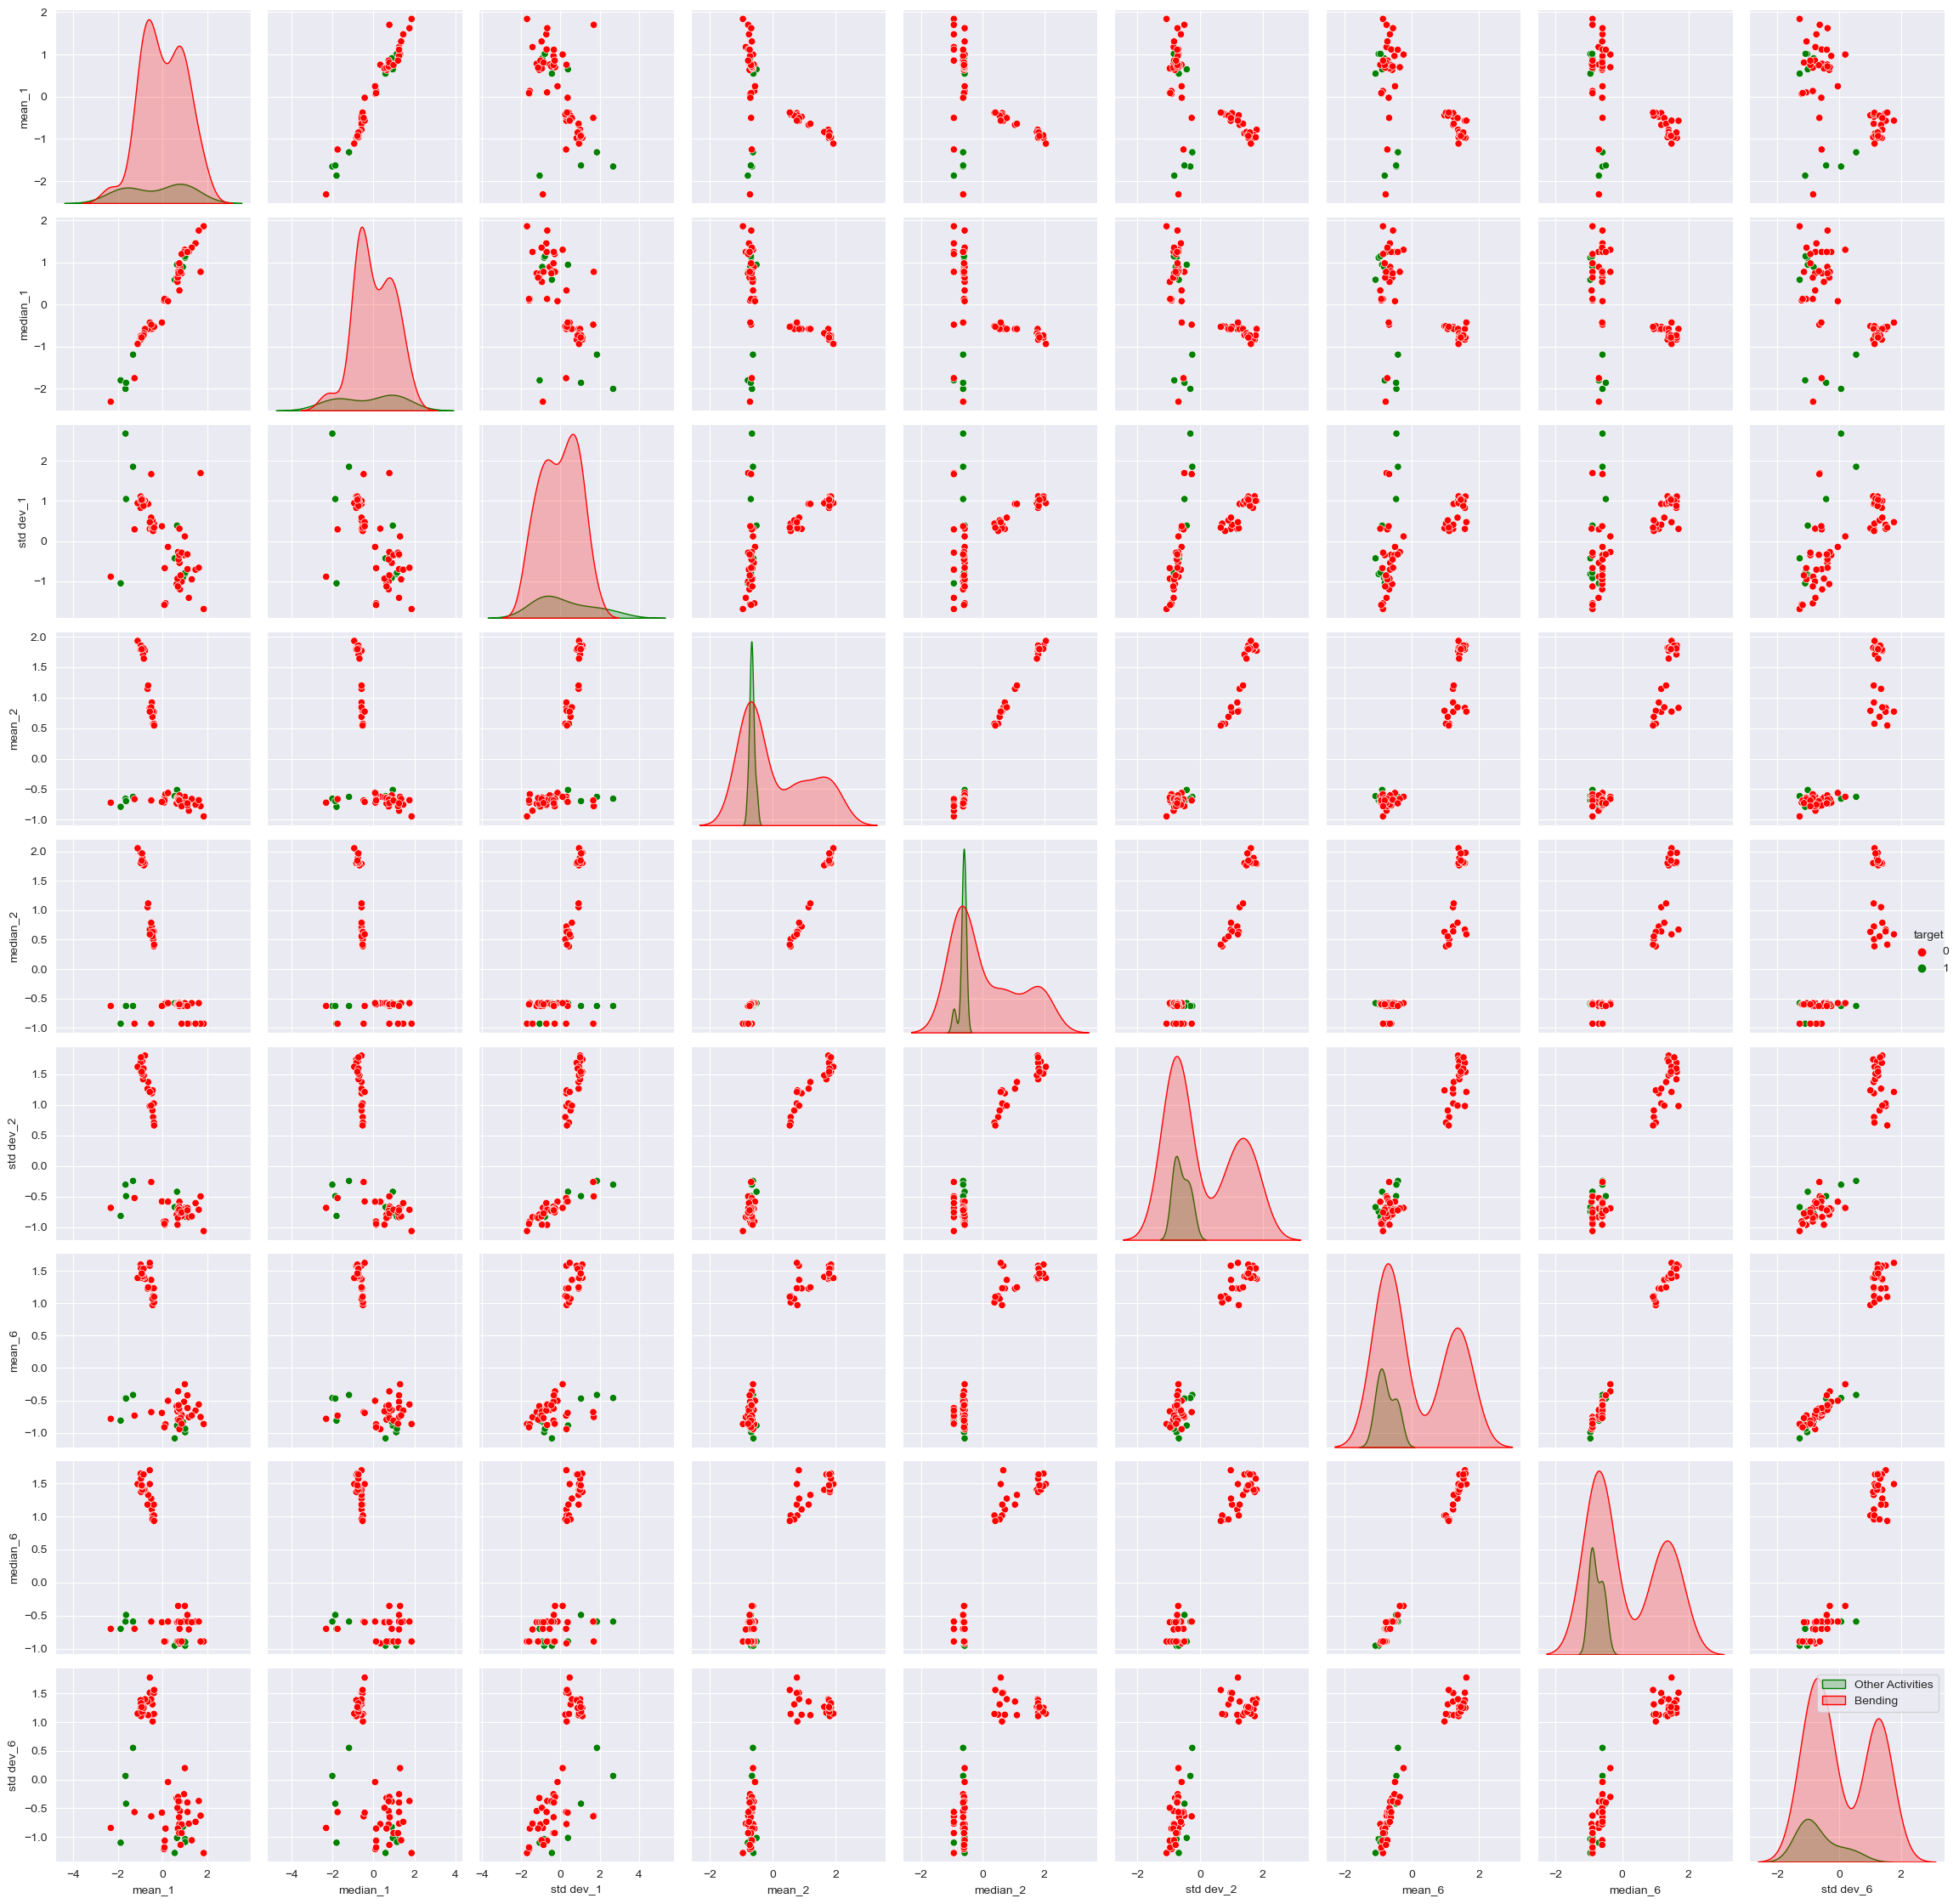

In [55]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(12, 10))
sns.pairplot(train_df_scaled, vars=features, hue='target', palette=custom_palette, diag_kind='kde')
plt.tight_layout()
plt.legend(['Other Activities', 'Bending'])
plt.show()

### Break each time series in your training set into two (approximately) equaling time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable diﬀerence in the results with those of 4(a)i?

- We will split the time series into two approximately equal parts and extract the features for each part. We will then create a scatter plot of the features extracted from both parts of time series 1, 2, and 6.
- We will then compare the results with those of the previous experiment (4(a)i) to see if there is any considerable difference.

In [81]:
def rename_columns(df, series, feature_suffix, feature_names):
    start_col = 3 + (series - 1) * 7  # Calculate starting index based on series
    for i, feature in enumerate(feature_names):
        new_col_name = f"{feature}_{series}_{feature_suffix}"
        df.rename(columns={df.columns[start_col + i + 2]: new_col_name}, inplace=True)

def process_df(train_df):
    
    # From the ques 1 c) iii. I've chosen mean, median and standard deviation as the three most important time-domain features
    # So, I'll select these features for the scatter plot below
    selected_features = ['mean', 'median', 'std dev']
    
    # Split the training data into two approximately equal parts based on the index
    df_first_half = train_df.iloc[:math.floor(len(train_df)/2)].copy()
    df_second_half = train_df.iloc[math.floor(len(train_df)/2):-1].copy()
    
    for series in [1, 2, 6]:
        rename_columns(df_first_half, series, '1', selected_features)
        rename_columns(df_second_half, series, '2', selected_features)
    
    df_first_half.reset_index(drop=True, inplace=True)
    df_second_half.reset_index(drop=True, inplace=True)

    # Now since we are working with two parts of the time series, we will combine the features from both parts and for 1,2,6 series
    selected_cols_first = [col for col in df_first_half.columns if any(f"{feature}_{series}_1" in col for feature in selected_features for series in [1, 2, 6])]
    selected_cols_second = [col for col in df_second_half.columns if any(f"{feature}_{series}_2" in col for feature in selected_features for series in [1, 2, 6])]

    df_break_feature = pd.concat([
        df_first_half[['activity'] + selected_cols_first],
        df_second_half[selected_cols_second]
    ], axis=1)

    df_break_feature['bending_label'] = (df_break_feature['activity'] == 'bending').astype(int)
    return df_break_feature


<Figure size 2000x2000 with 0 Axes>

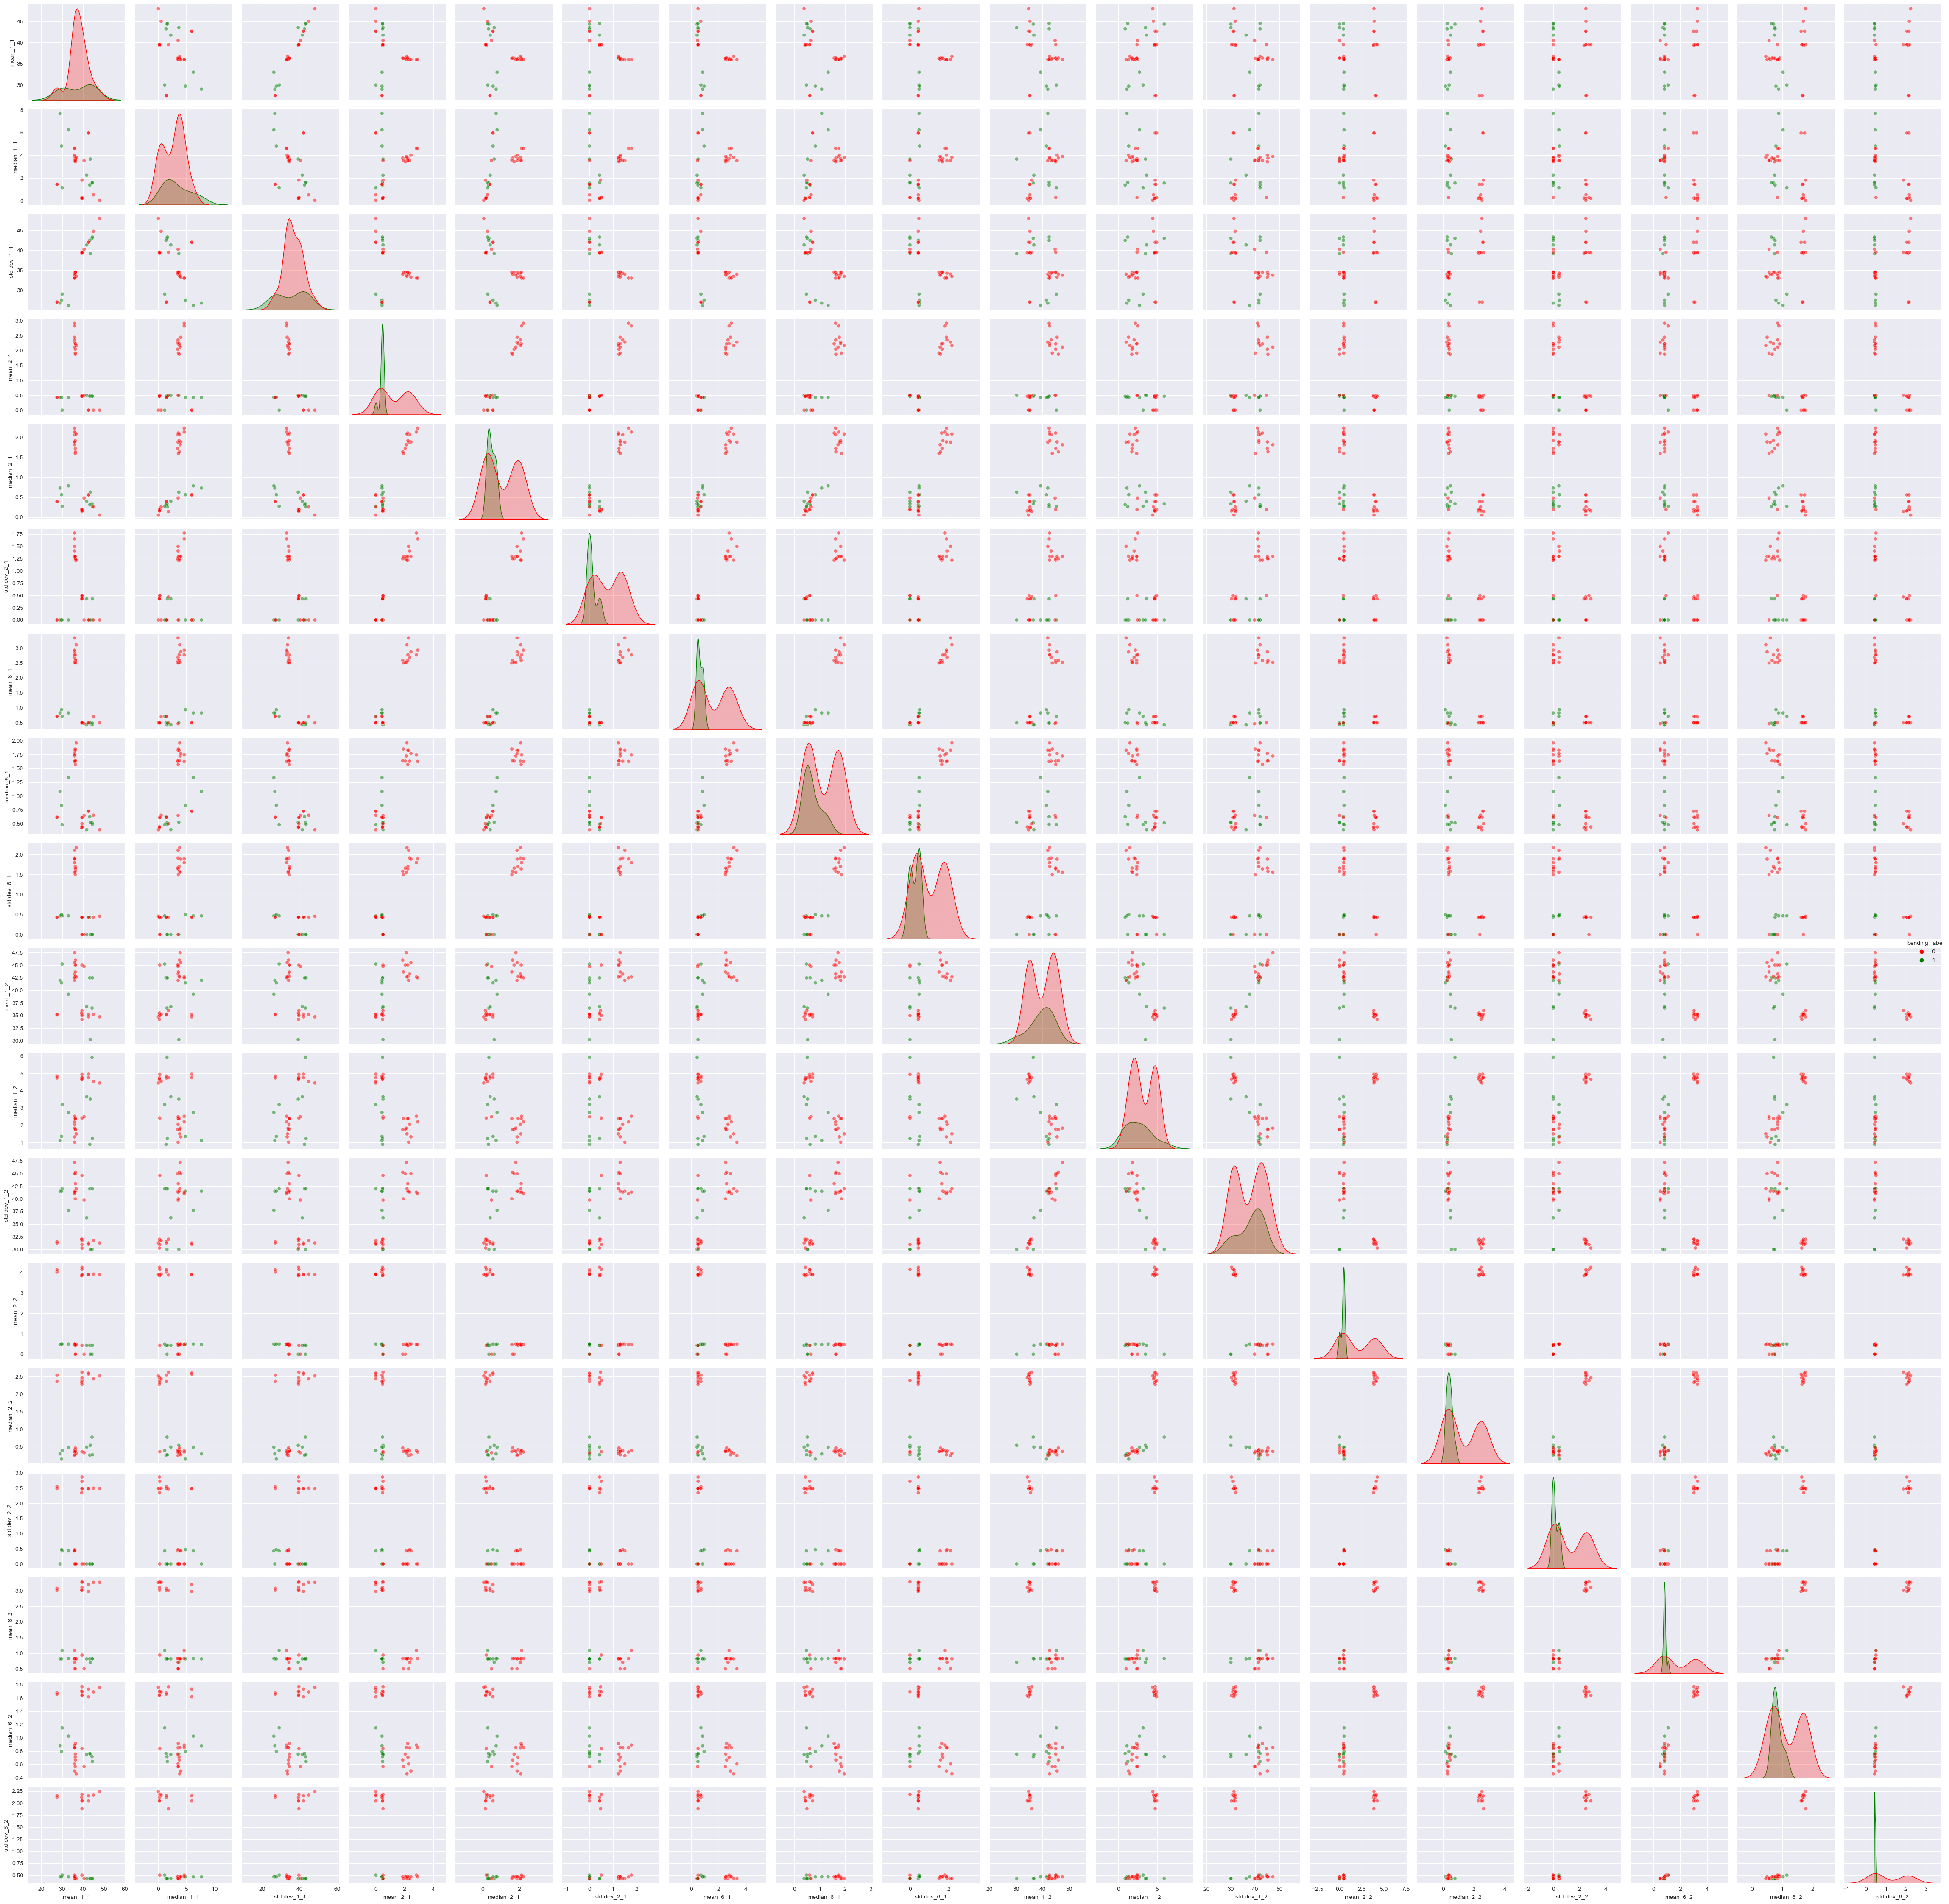

In [57]:
# Plot pair plots
df_break_feature = process_df(train_df)
plt.figure(figsize=(20, 20))
sns.pairplot(df_break_feature.drop('activity', axis=1), 
             vars=[col for col in df_break_feature.columns if col != 'bending_label' and col != 'activity'],
             hue="bending_label", 
             palette=custom_palette,
             plot_kws={'alpha': 0.5})
plt.tight_layout()
plt.show()

###### Findings: <br>
- The scatter plots for the features extracted from both parts of the time series show more separation between the bending and other activities compared to the previous experiment. This indicates that splitting the time series into two parts has improved the classification of bending vs. other activities.
- The features extracted from the two parts of the time series provide more information about the activities, leading to better separation between the classes.

target
0    0.87
1    0.13
Name: count, dtype: float64


Text(0.5, 1.0, 'Class Distribution')

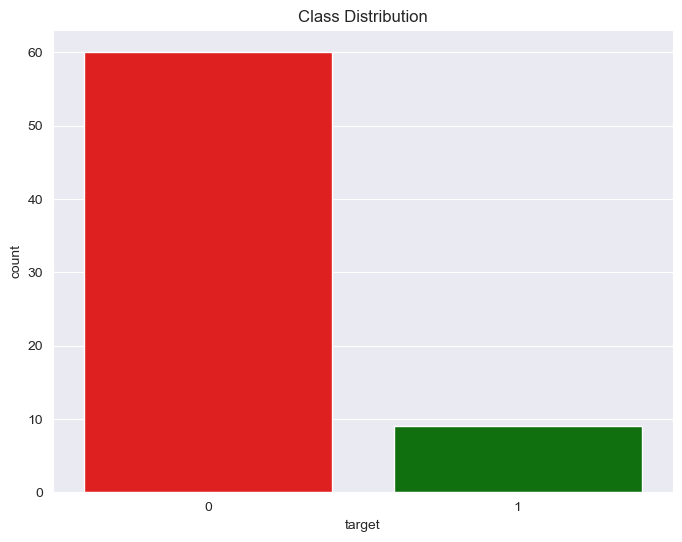

In [88]:
# Let's find out if the data has any imbalances
print(np.round(train_df['target'].value_counts()/train_df['target'].count(), 2))


plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df, palette=custom_palette)
plt.title('Class Distribution')


- From above we can see that the classes are imbalanced, with the 'other activities' class having a higher frequency than the 'bending' class. This imbalance can affect the performance of the classifier, especially for the minority class.

### iii. Break each time series in your training set into l ∈{1,2,...,20}time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l,p), where pis the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem. Use the right way! Also, you may encounter theproblem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.<br><br>
In the following, you can see an example of applying Python's Recursive Feature Elimination, which is a backward selection algorithm, to logistic re-gression.<br><br>
```
# Recursive Feature Elimination
from sklearn import datasets from sklearn. feature-selection import RFE from sklearn. linear model import LogisticRegression
# load the iris datasets
dataset = datasets.load iris
# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression (
# create the RFE model and select 3 attributes
rfe = RFE( model, 3)
rfe = rfe. fit (dataset.data, dataset. target)
# summarize the selection of the attributes
print (rfe. support.) print (rfe. ranking -)


* Note: I'm using all the features ( not selected as replied from intsructor on piazza  and processing) [here](https://piazza.com/class/m09cnglrrao1gr/post/412) for all the 840 rows in the dataset

##### Cross-Validation: 
* When we try to evaluate the performance of a machine learning model, we need to ensure that the evaluation is done in a fair and unbiased manner. Cross-validation is a technique used to evaluate the performance of a model by training and testing it on multiple subsets of the data. 

<center>
<img src= "https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width='500px' height='600px'/> 
</center>



 - Stratified K-Fold Cross-Validation is an advanced form of cross-validation that is particularly useful when working with datasets that have an unbalanced distribution of classes.
    - In this problem, we will use Stratified K-Fold Cross-Validation to ensure that each fold contains the same proportion of instances from each class, which is important when dealing with imbalanced datasets.
    - Stratified K-Fold Cross-Validation addresses this issue by ensuring that each fold is a good representative of the whole dataset.
    - It works by preserving the original distribution of classes in each fold, ensuring that the proportions between classes are conserved.

This approach makes sure that each class is adequately represented across all folds, allowing for a fair and accurate evaluation of the model’s performance.<br> <br> Check out more about [Stratified K-Fold Cross-Validation](https://medium.com/@juanc.olamendy/a-comprehensive-guide-to-stratified-k-fold-cross-validation-for-unbalanced-data-014691060f17)

In [150]:
# Let's define a function to extract features for each partition of the time series and perform feature selection using recursive feature elimination

def extract_features_for_partition(df, series_names):
    features = []
    for series in series_names:
        features.extend([
            df[series].min(),
            df[series].max(),
            df[series].mean(),
            df[series].median(),
            df[series].std(),
            df[series].quantile(0.25),
            df[series].quantile(0.75)
        ])
    return features

# The following function reads a CSV file, splits it into l partitions, and extracts features for each partition
def process_csv_file(file_path, l, series_names, is_bending):
    df = pd.read_csv(file_path, skiprows=4)
    
    # Check if 'time' column exists before trying to drop it
    if 'time' in df.columns:
        df = df.drop("time", axis=1)
    
    df_partitions = np.array_split(df, l)
    
    features = []
    for partition in df_partitions:
        features.extend(extract_features_for_partition(partition, series_names))
    
    features.append(1 if is_bending else 0)  
    return features

def extract_features_from_folder(folder_name, total_datasets, test_datasets, l):
    series_names = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
    is_bending = folder_name.startswith("bending")
    
    features = []
    for i in range(1, total_datasets + 1):
        file_path = f'../data/ARem/{folder_name}/dataset{i}.csv'
        csv_features = process_csv_file(file_path, l, series_names, is_bending)
        csv_features.append(1 if i <= test_datasets else 0) 
        features.append(csv_features)
    
    return features

def generate_feature_names(l):
    series_numbers = range(1, 7)
    # Considering all the features for each partition
    feature_types = ['min', 'max', 'mean', 'median', 'std dev', '1st quartile', '3rd quartile']   
    column_names = [f"{feature}_{series}_{i}" 
                    for i in range(1, l+1) 
                    for series in series_numbers 
                    for feature in feature_types]
    column_names.extend(["bending_label", "testing_label"])
    return column_names

def perform_feature_selection(l):

    all_features = []
    for folder, config in folders_config.items():
        all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], l))
    
    column_names = generate_feature_names(l)
    df_features = pd.DataFrame(all_features, columns=column_names)
    
    X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
    y_train = df_features[df_features['testing_label'] == 0]['bending_label']
    
    # Reference 
    # I'm setting max_ier = 10,000 to avoid convergence warnings 
    # Reference : https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
    # Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    model = LogisticRegression(max_iter=10000)
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X_train, y_train)
    
    return rfecv.n_features_, np.max(rfecv.cv_results_['mean_test_score'])


time_series_sizes = range(1, 21)
results = []

# printing out the optimal features and the cross-validation score for each value of l 
for l in time_series_sizes:
    optimal_features, cv_score = perform_feature_selection(l)
    results.append({"l": l, "p-features": optimal_features, "Score": cv_score})
    print(f"L={l}: Optimal features={optimal_features}, CV Score={cv_score}")



L=1: Optimal features=11, CV Score=0.9857142857142858
L=2: Optimal features=9, CV Score=0.9714285714285715
L=3: Optimal features=4, CV Score=0.9714285714285715
L=4: Optimal features=1, CV Score=0.9714285714285715
L=5: Optimal features=1, CV Score=0.9571428571428573
L=6: Optimal features=14, CV Score=0.9714285714285715
L=7: Optimal features=18, CV Score=0.9714285714285715
L=8: Optimal features=3, CV Score=0.9428571428571428
L=9: Optimal features=9, CV Score=0.9571428571428573
L=10: Optimal features=12, CV Score=0.9571428571428573
L=11: Optimal features=2, CV Score=0.9571428571428573
L=12: Optimal features=5, CV Score=0.9571428571428573
L=13: Optimal features=1, CV Score=0.9571428571428573
L=14: Optimal features=23, CV Score=0.9714285714285715
L=15: Optimal features=1, CV Score=0.9428571428571428
L=16: Optimal features=28, CV Score=0.9714285714285715
L=17: Optimal features=1, CV Score=0.9571428571428573
L=18: Optimal features=1, CV Score=0.9714285714285715
L=19: Optimal features=1, CV Sc

In [151]:
# To choose the best value of l, we will sort the results by the CV score in descending order
# If the CV scores are the same, we will choose the smallest l
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_results.to_string(index=False))

 l  p-features    Score
 1          11 0.985714
 2           9 0.971429
 3           4 0.971429
 4           1 0.971429
 6          14 0.971429
 7          18 0.971429
14          23 0.971429
16          28 0.971429
18           1 0.971429
19           1 0.971429
20          10 0.971429
 5           1 0.957143
 9           9 0.957143
10          12 0.957143
11           2 0.957143
12           5 0.957143
13           1 0.957143
17           1 0.957143
 8           3 0.942857
15           1 0.942857


 - The above table shows the optimal number of features and the cross-validation score for each value of l. I'm choosing best pair as ```(l=1, p=11)``` as it has the highest cross-validation score of ```0.98571```
1. The right way to perform cross-validation in this problem,is to include both the feature selection and model training within the cross-validation loop.
   - This ensures that the feature selection process doesn't have access to the validation data, preventing overfitting and providing a more realistic estimate of model performance.
<br>
2. The wrong way would be to perform feature selection on the entire dataset before cross-validation, which could lead to overly optimistic performance estimates and potential overfitting.



<center> <img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  alt ='Understand Better' width='500px' height='600px'/>
</center>

In [152]:
# Extract features for the best pair of l and p values
all_features = []
for folder, config in folders_config.items():
    # I'm choosing l =1 
    all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], 1))

column_names = generate_feature_names(1)
df_features = pd.DataFrame(all_features, columns=column_names)

# Split into train and test sets
X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
y_train = df_features[df_features['testing_label'] == 0]['bending_label']
X_test = df_features[df_features['testing_label'] == 1].iloc[:, :-2]
y_test = df_features[df_features['testing_label'] == 1]['bending_label']

# Perform feature selection
model = LogisticRegression(max_iter=10000)
# rfe --> Recursive Feature Elimination docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
rfe = RFE(model, n_features_to_select=11)
rfe = rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_].tolist()

print("Selected features:")
for feature in selected_features:
    print(feature)

# Train final model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
final_model = LogisticRegression(max_iter=10000, solver='liblinear')
final_model.fit(X_train_selected, y_train)

# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(selected_features, final_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")

# Calculate and print model accuracy
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Selected features:
mean_1_1
3rd quartile_1_1
max_2_1
min_3_1
median_3_1
1st quartile_3_1
min_5_1
max_5_1
mean_5_1
1st quartile_5_1
3rd quartile_5_1

Model Coefficients:
mean_1_1: -0.2937
3rd quartile_1_1: -0.4079
max_2_1: -0.3703
min_3_1: -0.1771
median_3_1: -0.2020
1st quartile_3_1: -0.0073
min_5_1: 0.4435
max_5_1: 0.6133
mean_5_1: 0.2526
1st quartile_5_1: 0.3029
3rd quartile_5_1: 0.0951

Training Accuracy: 1.0000
Test Accuracy: 1.0000


#### iv. Report the confusion matrix and show the ROC and AUC for your classifier in train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [153]:
# Calculate confusion matrix for training data
y_train_pred = final_model.predict(X_train_selected)
cm_train = confusion_matrix(y_train, y_train_pred)
print("\nConfusion Matrix (Training Data):")
print(cm_train)


Confusion Matrix (Training Data):
[[60  0]
 [ 0  9]]


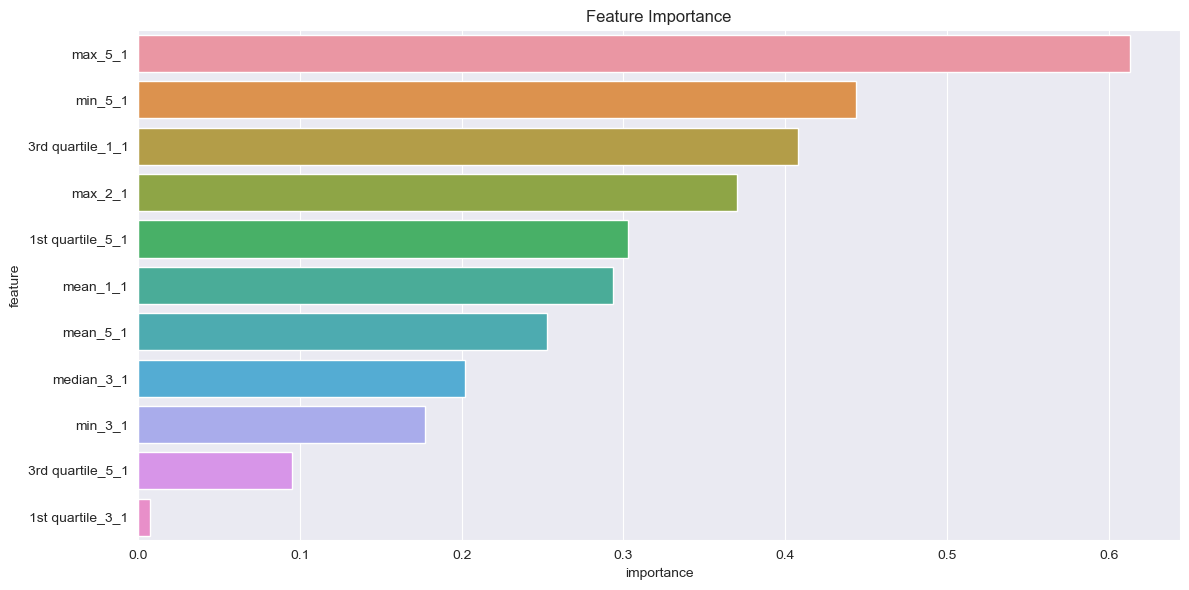

In [154]:
# Visualize feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({'feature': selected_features, 'importance': abs(final_model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


- The confusion matrix for the training data shows that the model is able to predict the classes with high accuracy. The feature importance plot indicates the importance of each feature in the logistic regression model.

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
<br>
- [Reference](https://www.kaggle.com/discussions/general/343302)
- [Docs](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

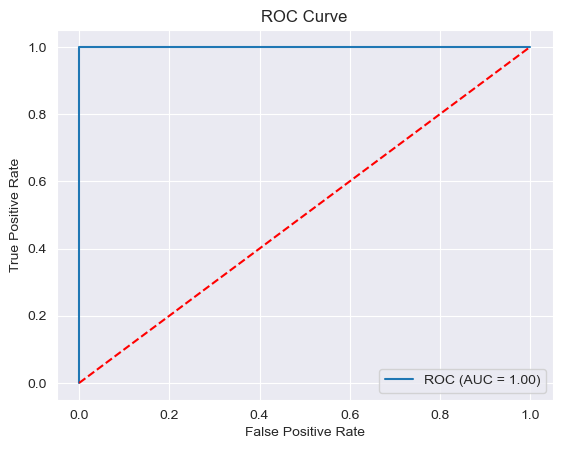

In [155]:
# Plot ROC curve and AUC score
rfe_score = roc_auc_score(y_train, rfe.predict_proba(X_train)[:, 1])
# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_train, rfe.predict_proba(X_train)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='ROC (AUC = %0.2f)' % rfe_score)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

* Inference: 
  The ROC curve and AUC score for the training data show that the model performs well in distinguishing between the classes. The AUC score of 1.00 indicates that the model has a high ability to separate the classes.

In [170]:
# Calculate p-values for the logistic regression parameters
X_train_selected = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_selected)
result = logit_model.fit() 
result.summary()

         Current function value: 0.000000
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          bending_label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            5
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        19:36:55   Log-Likelihood:            -3.6209e-09
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.738e-10
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.3802   1.05e+06   1.08e-05      1.000   -2.06e+06    2.06e+06
3rd quartile_1_1    -4.9349   4.53e+04     -0.000      1.000   -8.88e+04    8.88e+04
min_5_1              5.5970   1.02e+05   5.49e-05      1.000      -2e+05       2e+05
max_5_1              5.7841   7.06e+04    8.2e-05      1.000   -1.38e+05    1.38e+05
median_6_1         -22.2620   1.92e+06  -1.16e-05      1.000   -3.75e+06    3.75e+06
1st quartile_6_1     8.8145   9.69e+05    9.1e-06      1.000    -1.9e+06     1.9e+06
====================================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

- The above table shows the estimated parameters and p-values for the logistic regression model. The p-values for each parameters has  p> alpha = 0.05, which indicates that the parameters are not statistically significant. So, we fail to reject the null hypothesis for all the parameters.

#### v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [157]:
# Test the classifier on the test set
X_test = df_features[df_features['testing_label'] == 1].iloc[:, :-2]
y_test = df_features[df_features['testing_label'] == 1]['bending_label']
X_test_selected = X_test[selected_features]

# Calculate and print model accuracy by fitting the test data to the model using number of selected features = 11
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compare with cross-validation accuracy
print(f"Cross-Validation Accuracy: {cv_score:.4f}")



Test Accuracy: 1.0000
Cross-Validation Accuracy: 0.9714


- The test score which is higher than the cross-validation accuracy,the accuracy on the test set is same as the training accuracy, which indicates that the model is not overfitting.

#### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
- Yes, the classes seem to be well-separated, which can cause instability in calculating logistic regression parameters. The feature importance plot shows that the features are not well-separated, which can lead to overfitting and instability in the model.

In [158]:
precision = cm_train[1, 1] / (cm_train[1, 1] + cm_train[0, 1])
recall = cm_train[1, 1] / (cm_train[1, 1] + cm_train[1, 0])
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_train, y_train_pred)
print(f"F1 Score: {f1:.4f}")


Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


#### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

- I have already determined that the classes are imbalanced, with the 'other activities' class having a higher frequency than the 'bending' class. This imbalance can affect the performance of the classifier, especially for the minority class.
- One method to handle imbalanced classes is to use case-control sampling, which involves oversampling the minority class to balance the class distribution.
- I'm using SMOTE --> synthetic minority oversampling technique to oversample the minority class and balance the class distribution.


In [159]:
# Perform case-control sampling using SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# Train logistic regression model with resampled data
model_resampled = LogisticRegression(max_iter=10000, solver='liblinear')
model_resampled.fit(X_train_resampled, y_train_resampled)

# Calculate and print model accuracy
train_accuracy_resampled = model_resampled.score(X_train_resampled, y_train_resampled)
print(f"Training Accuracy (Resampled): {train_accuracy_resampled:.4f}")


Training Accuracy (Resampled): 1.0000


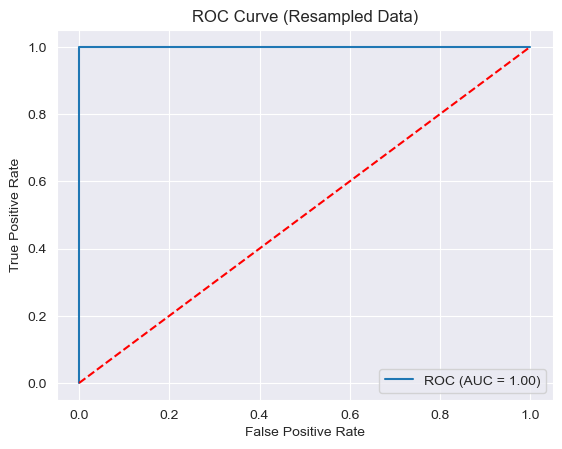

In [160]:
# Calculate ROC curve and AUC for resampled data   
rfe_score_resampled = roc_auc_score(y_train_resampled, model_resampled.predict_proba(X_train_resampled)[:, 1])
fpr_resampled, tpr_resampled, _ = roc_curve(y_train_resampled, model_resampled.predict_proba(X_train_resampled)[:, 1])
plt.figure()
plt.plot(fpr_resampled, tpr_resampled, label='ROC (AUC = %0.2f)' % rfe_score_resampled)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Resampled Data)')
plt.legend(loc="lower right")
plt.show()


- The confusion matrix for the resampled test data shows that the model is able to predict the classes with high accuracy. The ROC curve and AUC score for the resampled data also indicate that the model performs well in distinguishing between the classes, which is similar to the results obtained from the original data.

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Repeat 4(a)iii using L1-penalized logistic regression,8 i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

-  Lasso regression (L1 regularization) adds an L1 penalty term to the cost function, which helps in feature selection by shrinking the coefficients of less important features to zero. This allows for automatic feature selection and can help in reducing overfitting.
- It takes the absolute value of the coefficients as the penalty term, which can lead to sparsity in the coefficients, effectively performing feature selection.

 [Reference](https://www.kaggle.com/code/brysonjbanks/an-exploration-of-l1-and-l2-regularization#What-is-Regularization?)



In [178]:
def perform_feature_selection_l1(l):
    all_features = []
    for folder, config in folders_config.items():
        all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], l))
    
    column_names = generate_feature_names(l)
    df_features = pd.DataFrame(all_features, columns=column_names)
    
    X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
    y_train = df_features[df_features['testing_label'] == 0]['bending_label']
    
    # Use standard scaler to scale the features and also grid search for the best C value
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
    
    # Perform grid search to find the best C value for L1 regularization
    # The hyperparameter C is the inverse of the regularization strength (λ)
    param_grid = {'C': np.logspace(-3, 7, 7)} # I'm using logspace to get a range of values for C
    
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search.best_estimator_.coef_, grid_search.best_score_

time_series_sizes = range(1, 21)
results_l1 = []

for l in time_series_sizes:
    optimal_features, cv_score = perform_feature_selection_l1(l)
    # Count the number of selected features
    n_features = np.count_nonzero(optimal_features)
    results_l1.append({"l": l, "p-features": n_features, "Score": cv_score})
    print(f"L={l}: Optimal features={n_features}, CV Score={cv_score}")
    
df_results_l1 = pd.DataFrame(results_l1)
df_results_l1 = df_results_l1.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_results_l1.to_string(index=False))


L=1: Optimal features=8, CV Score=0.9714285714285715
L=2: Optimal features=9, CV Score=0.9571428571428573
L=3: Optimal features=9, CV Score=0.9571428571428573
L=4: Optimal features=10, CV Score=0.9571428571428573
L=5: Optimal features=22, CV Score=0.9428571428571428
L=6: Optimal features=14, CV Score=0.9428571428571428
L=7: Optimal features=12, CV Score=0.956043956043956
L=8: Optimal features=17, CV Score=0.9417582417582417
L=9: Optimal features=14, CV Score=0.9571428571428573
L=10: Optimal features=14, CV Score=0.9571428571428573
L=11: Optimal features=9, CV Score=0.9417582417582417
L=12: Optimal features=10, CV Score=0.9571428571428573
L=13: Optimal features=11, CV Score=0.9571428571428573
L=14: Optimal features=13, CV Score=0.9428571428571428
L=15: Optimal features=19, CV Score=0.9417582417582417
L=16: Optimal features=18, CV Score=0.9274725274725275
L=17: Optimal features=47, CV Score=0.9571428571428573
L=18: Optimal features=10, CV Score=0.9703296703296704
L=19: Optimal features=1

In [179]:
all_features = []
for folder, config in folders_config.items():
    all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], 1))
    
column_names = generate_feature_names(1)
df_features = pd.DataFrame(all_features, columns=column_names)

# Split into train and test sets
X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
y_train = df_features[df_features['testing_label'] == 0]['bending_label']
X_test = df_features[df_features['testing_label'] == 1].iloc[:, :-2]
y_test = df_features[df_features['testing_label'] == 1]['bending_label']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform L1 feature selection
model = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
rvce = RFECV(estimator=model, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
rvce.fit(X_train_scaled, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_].tolist()

print("Selected features:")
for feature in selected_features:
    print(feature)
    
# Train final model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
final_model = LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear')
final_model.fit(X_train_selected, y_train)
    
# Print model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(selected_features, final_model.coef_[0]):
    print(f"{feature}: {coef:.4f}")
    
# Calculate and print model accuracy
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Selected features:
3rd quartile_1_1
min_5_1
max_5_1
median_6_1
1st quartile_6_1

Model Coefficients:
3rd quartile_1_1: -0.5795
min_5_1: 0.5947
max_5_1: 0.6861
median_6_1: -0.8267
1st quartile_6_1: 0.0000

Training Accuracy: 1.0000
Test Accuracy: 1.0000


In [180]:
# Calculate the p-values for the logistic regression parameters
X_train_selected = sm.add_constant(X_train_selected)
logit_model = sm.Logit(y_train, X_train_selected)
result = logit_model.fit(method='lbfgs')
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.55012D+01

At iterate    1    f=  4.67349D-01    |proj g|=  3.35285D+00

At iterate    2    f=  4.14715D-01    |proj g|=  2.48029D+00

At iterate    3    f=  3.86263D-01    |proj g|=  3.98715D+00

At iterate    4    f=  3.63388D-01    |proj g|=  1.14600D+00

At iterate    5    f=  3.42960D-01    |proj g|=  9.93766D-01

At iterate    6    f=  1.84825D-01    |proj g|=  9.27696D-01

At iterate    7    f=  1.22576D-01    |proj g|=  2.15548D-01

At iterate    8    f=  8.74296D-02    |proj g|=  3.40456D-01

At iterate    9    f=  5.78512D-02    |proj g|=  2.00302D-01

At iterate   10    f=  3.46661D-02    |proj g|=  8.80291D-02

At iterate   11    f=  1.89245D-02    |proj g|=  7.84461D-02

At iterate   12    f=  1.02185D-02    |proj g|=  1.13366D-01

At iterate   13    f=  6.3

 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          bending_label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            5
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                   1.000
Time:                        19:45:36   Log-Likelihood:            -1.9040e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.738e-10
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3089   3.36e+04   -9.2e-06      1.000   -6.58e+04    6.58e+04
3rd quartile_1_1    -3.7189   1614.452     -0.002      0.998   -3167.987    3160.550
min_5_1              4.0560   1319.664      0.003      0.998   -2582.438    2590.550
max_5_1              4.4614   2953.617      0.002      0.999   -5784.522    5793.444
median_6_1          -3.7577   2.24e+04     -0.000      1.000   -4.38e+04    4.38e+04
1st quartile_6_1    -2.6590   2.74e+04  -9.69e-05      1.000   -5.38e+04    5.38e+04
====================================================================================

Complete Separation: The results show that there iscomplete separation or perfect prediction.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

 - The test accuracy for the best model is 1.0000 and train accuracy is 1.000. The model performs well on the test set and does not overfit the training data. The p-values for the logistic regression parameters are  comparetively having better p-values than the previous model.

#### ii.  Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?
<br>
L1 penalised logistic regression is better than variable selection using p-values because: it has better 

-

### (c) Multi-class Classification (The Realistic Case)

#### i. Find the best l in the same way as you found it in 4(b)i to build an L1-penalized multinomial regression model to classify all activities in your training set.  Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.


- In multi-class classification, we need to consider all the classes present in the dataset and build a model that can classify instances into multiple classes.
- We will use L1-penalized multinomial regression to classify all activities in the training set. To acheive that, we use ```onevsrestclassifier``` which is a strategy that involves fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

- More on [this](https://scikit-learn.org/stable/modules/multiclass.html)

In [201]:
def feature_selection_multiclass(l, folders_config):
    all_features = []
    for folder, config in folders_config.items():
        all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], l))
    
    column_names = generate_feature_names(l)
    df_features = pd.DataFrame(all_features, columns=column_names)
    
    X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
    y_train = df_features[df_features['testing_label'] == 0]['bending_label']
    
    # Trying to scale the features and also grid search for the best C value   
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # The label encoder is used to encode the target labels into integers 
    # We do this because the Logistic Regression model requires the target labels to be integers
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    
    model = OneVsRestClassifier(LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear', multi_class='ovr'))
    param_grid = {'estimator__C': np.logspace(-3, 3, 7)}
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_encoded)
    
    return grid_search.best_estimator_, grid_search.best_score_, scaler, le


# Find the best l
time_series_sizes = range(1, 21)
results_l1 = []

for l in time_series_sizes:
    best_model, cv_score, _, _ = feature_selection_multiclass(l, folders_config)
    # Calculate the number of selected features for the best model
    n_features = np.sum([np.count_nonzero(clf.coef_) for clf in best_model.estimators_])
    results_l1.append({"l": l, "p-features": n_features, "Score": cv_score})
    print(f"L={l}: Selected features={n_features}, CV Score={cv_score}")

df_results_l1 = pd.DataFrame(results_l1)
df_results_l1 = df_results_l1.sort_values(by=["Score", "l"], ascending=[False, True])
print(df_results_l1.to_string(index=False))


L=1: Selected features=7, CV Score=0.9714285714285715
L=2: Selected features=11, CV Score=0.9428571428571428
L=3: Selected features=8, CV Score=0.9571428571428573
L=4: Selected features=10, CV Score=0.9571428571428573
L=5: Selected features=11, CV Score=0.9571428571428573
L=6: Selected features=18, CV Score=0.9571428571428573
L=7: Selected features=13, CV Score=0.9714285714285715
L=8: Selected features=14, CV Score=0.9417582417582417
L=9: Selected features=17, CV Score=0.9571428571428573
L=10: Selected features=13, CV Score=0.9571428571428573
L=11: Selected features=8, CV Score=0.9417582417582417
L=12: Selected features=8, CV Score=0.9571428571428573
L=13: Selected features=11, CV Score=0.9571428571428573
L=14: Selected features=12, CV Score=0.9285714285714285
L=15: Selected features=14, CV Score=0.9417582417582417
L=16: Selected features=13, CV Score=0.9274725274725275
L=17: Selected features=50, CV Score=0.9285714285714285
L=18: Selected features=8, CV Score=0.9703296703296704
L=19: 

In [202]:
# Use the best l to train the final model
best_l = int(df_results_l1.iloc[0]['l'])  
best_model, _, scaler, le = feature_selection_multiclass(best_l, folders_config)

# Prepare test data
all_features = []
for folder, config in folders_config.items():
    all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], best_l))

column_names = generate_feature_names(best_l)
df_features = pd.DataFrame(all_features, columns=column_names)

X_test = df_features[df_features['testing_label'] == 1].iloc[:, :-2]
y_test = df_features[df_features['testing_label'] == 1]['bending_label']

X_test_scaled = scaler.transform(X_test)
y_test_encoded = le.transform(y_test)

# Make predictions
y_test_pred = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 1.0000


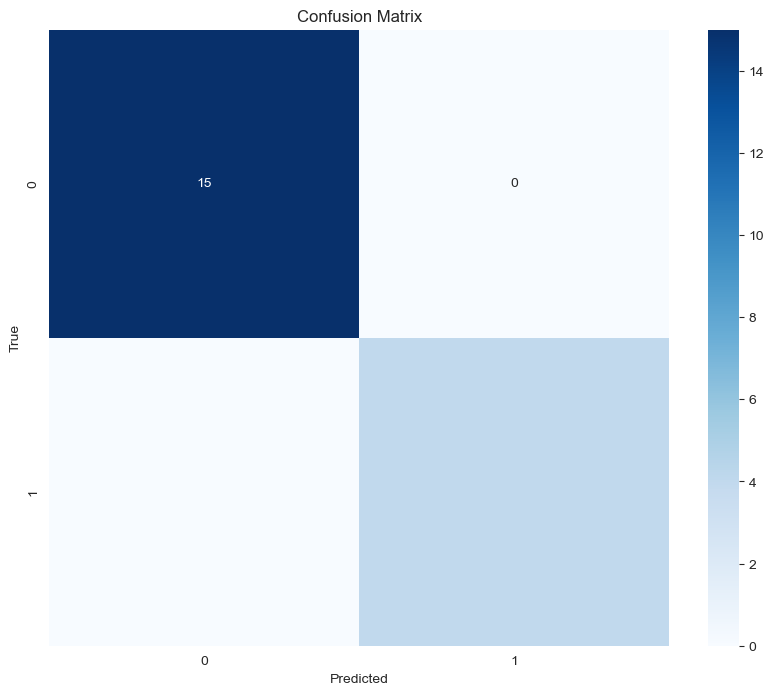

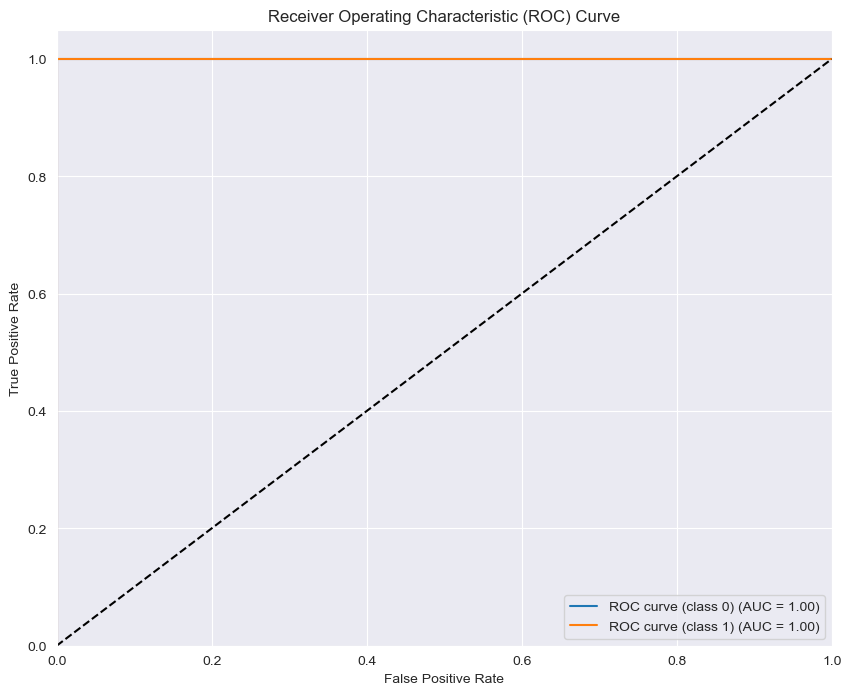

In [203]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
y_test_proba = best_model.predict_proba(X_test_scaled)
n_classes = len(le.classes_)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {le.classes_[i]}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

- The above graph, shows that the model performs well in classifying the activities, with high AUC scores for each class. The confusion matrix also indicates that the model is able to predict the classes with high accuracy. The test accuracy is 1.0000, which indicates that the model performs well on the test set.

#### Repeat 4(c)i using a Naive Bayes’s classifier. Use both Gaussian and Multi-nomial priors and compare the results.

In [194]:
def perform_naive_bayes_classification(l, folders_config, nb_type='gaussian'):
    all_features = []
    for folder, config in folders_config.items():
        all_features.extend(extract_features_from_folder(folder, config['total'], config['test'], l))
    
    column_names = generate_feature_names(l)
    df_features = pd.DataFrame(all_features, columns=column_names)
    
    X_train = df_features[df_features['testing_label'] == 0].iloc[:, :-2]
    y_train = df_features[df_features['testing_label'] == 0]['bending_label']
    X_test = df_features[df_features['testing_label'] == 1].iloc[:, :-2]
    y_test = df_features[df_features['testing_label'] == 1]['bending_label']
    
    # Choose appropriate scaler based on Naive Bayes type
    if nb_type == 'gaussian':
        scaler = StandardScaler()
    elif nb_type == 'multinomial':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid Naive Bayes type. Choose 'gaussian' or 'multinomial'.")
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    
    if nb_type == 'gaussian':
        model = GaussianNB()
    elif nb_type == 'multinomial':
        model = MultinomialNB()
    
    model.fit(X_train_scaled, y_train_encoded)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    
    return model, accuracy, X_test_scaled, y_test_encoded, le

# Find the best l for both Gaussian and Multinomial Naive Bayes
time_series_sizes = range(1, 21)
results_gaussian = []
results_multinomial = []

for l in time_series_sizes:
    # Perform Gaussian Naive Bayes classification
    _, accuracy_gaussian, _, _, _ = perform_naive_bayes_classification(l, folders_config, 'gaussian')
    
    # Perform Multinomial Naive Bayes classification
    _, accuracy_multinomial, _, _, _ = perform_naive_bayes_classification(l, folders_config, 'multinomial')
    
    # Store the results
    results_gaussian.append({"l": l, "Accuracy": accuracy_gaussian})
    results_multinomial.append({"l": l, "Accuracy": accuracy_multinomial})
    
    print(f"L={l}: Gaussian NB Accuracy={accuracy_gaussian:.4f}, Multinomial NB Accuracy={accuracy_multinomial:.4f}")



df_results_gaussian = pd.DataFrame(results_gaussian)
df_results_multinomial = pd.DataFrame(results_multinomial)


L=1: Gaussian NB Accuracy=0.5789, Multinomial NB Accuracy=0.9474
L=2: Gaussian NB Accuracy=0.5263, Multinomial NB Accuracy=0.8947
L=3: Gaussian NB Accuracy=0.5263, Multinomial NB Accuracy=0.8421
L=4: Gaussian NB Accuracy=0.5263, Multinomial NB Accuracy=0.7368
L=5: Gaussian NB Accuracy=0.5263, Multinomial NB Accuracy=0.7368
L=6: Gaussian NB Accuracy=0.4737, Multinomial NB Accuracy=0.6842
L=7: Gaussian NB Accuracy=0.4737, Multinomial NB Accuracy=0.6842
L=8: Gaussian NB Accuracy=0.4737, Multinomial NB Accuracy=0.6842
L=9: Gaussian NB Accuracy=0.5263, Multinomial NB Accuracy=0.6842
L=10: Gaussian NB Accuracy=0.4737, Multinomial NB Accuracy=0.6842
L=11: Gaussian NB Accuracy=0.5789, Multinomial NB Accuracy=0.6316
L=12: Gaussian NB Accuracy=0.6316, Multinomial NB Accuracy=0.6316
L=13: Gaussian NB Accuracy=0.6316, Multinomial NB Accuracy=0.6316
L=14: Gaussian NB Accuracy=0.6842, Multinomial NB Accuracy=0.6316
L=15: Gaussian NB Accuracy=0.5789, Multinomial NB Accuracy=0.6316
L=16: Gaussian NB A

In [195]:
# Display the results
df_bestp = pd.DataFrame(results_gaussian)
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by=["Accuracy", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  Accuracy
20  0.789474
16  0.736842
17  0.736842
14  0.684211
18  0.684211
19  0.684211
12  0.631579
13  0.631579
 1  0.578947
11  0.578947
15  0.578947
 2  0.526316
 3  0.526316
 4  0.526316
 5  0.526316
 9  0.526316
 6  0.473684
 7  0.473684
 8  0.473684
10  0.473684


In [196]:
df_bestp = pd.DataFrame(results_multinomial)
df_bestp.index = np.arange(1, 21)
df_bestp = df_bestp.sort_values(by=["Accuracy", "l"], ascending=[False, True])
print(df_bestp.to_string(index=False))

 l  Accuracy
 1  0.947368
 2  0.894737
 3  0.842105
 4  0.736842
 5  0.736842
 6  0.684211
 7  0.684211
 8  0.684211
 9  0.684211
10  0.684211
11  0.631579
12  0.631579
13  0.631579
14  0.631579
15  0.631579
16  0.631579
17  0.631579
18  0.631579
19  0.631579
20  0.631579


In [77]:
# Identify the best l for each classifier
best_l_gaussian = df_results_gaussian.loc[df_results_gaussian['Accuracy'].idxmax()]['l']
best_l_multinomial = df_results_multinomial.loc[df_results_multinomial['Accuracy'].idxmax()]['l']

print(f"\nBest l for Gaussian NB: {best_l_gaussian}")
print(f"Best l for Multinomial NB: {best_l_multinomial}")

# Train final models with the best l
gaussian_model, gaussian_accuracy, X_test_scaled_gaussian, y_test_encoded_gaussian, le_gaussian = perform_naive_bayes_classification(int(best_l_gaussian), folders_config, 'gaussian')
multinomial_model, multinomial_accuracy, X_test_scaled_multinomial, y_test_encoded_multinomial, le_multinomial = perform_naive_bayes_classification(int(best_l_multinomial), folders_config, 'multinomial')

print(f"\nGaussian NB Test Accuracy: {gaussian_accuracy:.4f}")
print(f"Multinomial NB Test Accuracy: {multinomial_accuracy:.4f}")


Best l for Gaussian NB: 1.0
Best l for Multinomial NB: 13.0

Gaussian NB Test Accuracy: 0.8947
Multinomial NB Test Accuracy: 0.8947


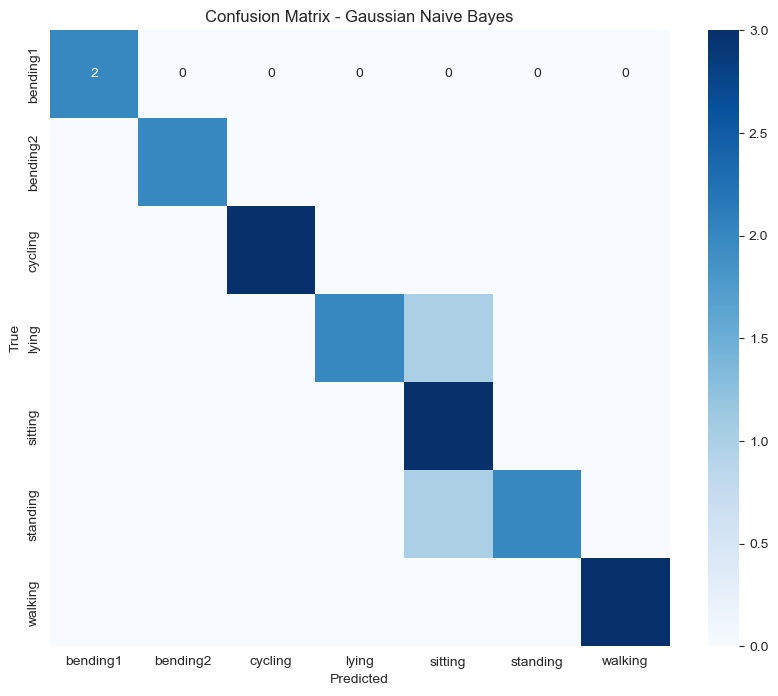

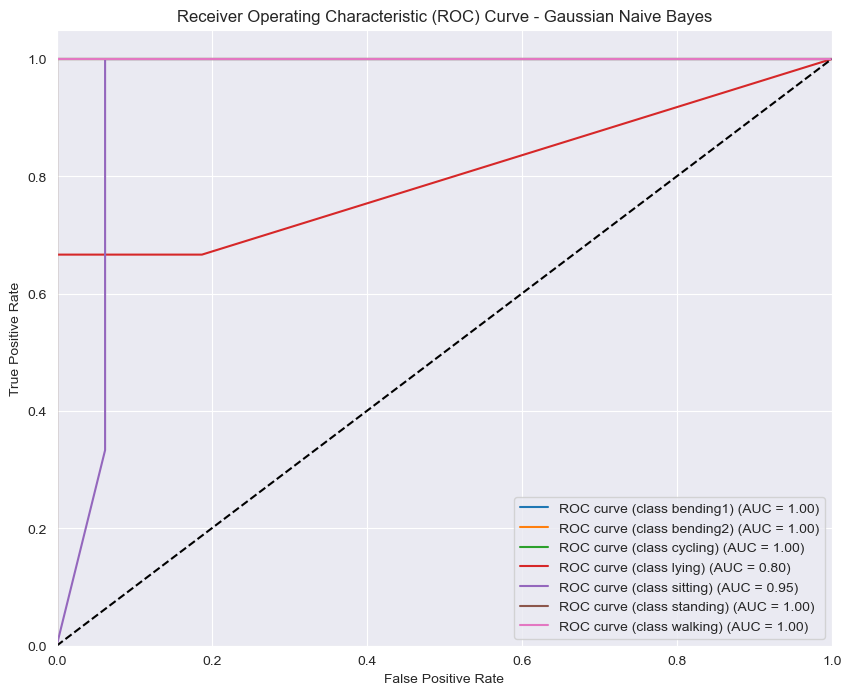

In [197]:
# Confusion Matrix for Gaussian NB
cm_gaussian = confusion_matrix(y_test_encoded_gaussian, gaussian_model.predict(X_test_scaled_gaussian))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gaussian, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_gaussian.classes_, yticklabels=le_gaussian.classes_)
plt.title('Confusion Matrix - Gaussian Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for Gaussian NB
y_test_proba_gaussian = gaussian_model.predict_proba(X_test_scaled_gaussian)
n_classes_gaussian = len(le_gaussian.classes_)

fpr_gaussian = dict()
tpr_gaussian = dict()
roc_auc_gaussian = dict()

for i in range(n_classes_gaussian):
    fpr_gaussian[i], tpr_gaussian[i], _ = roc_curve(y_test_encoded_gaussian == i, y_test_proba_gaussian[:, i])
    roc_auc_gaussian[i] = auc(fpr_gaussian[i], tpr_gaussian[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes_gaussian):
    plt.plot(fpr_gaussian[i], tpr_gaussian[i], label=f'ROC curve (class {le_gaussian.classes_[i]}) (AUC = {roc_auc_gaussian[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()


- The confusion matrix and ROC curve for the Gaussian Naive Bayes classifier show that the model performs well in classifying the activities. The AUC scores for each class indicate that the model can distinguish between the classes effectively.
The auc for lying and sitting are ```0.8``` and  ```0.95``` respectively, and rest of the classes have ```1.0``` auc score.
We can infer that the model performs well in classifying the activities, with high AUC scores for each class.

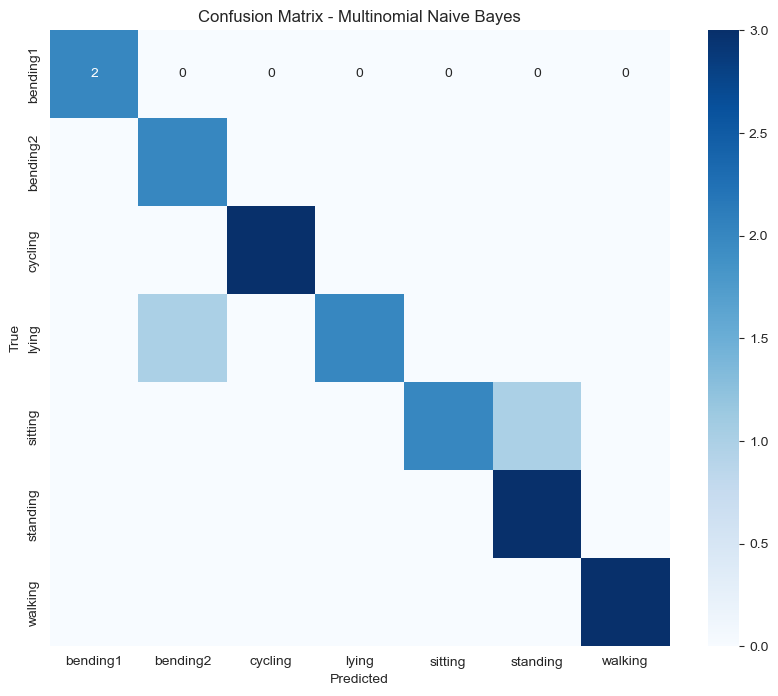

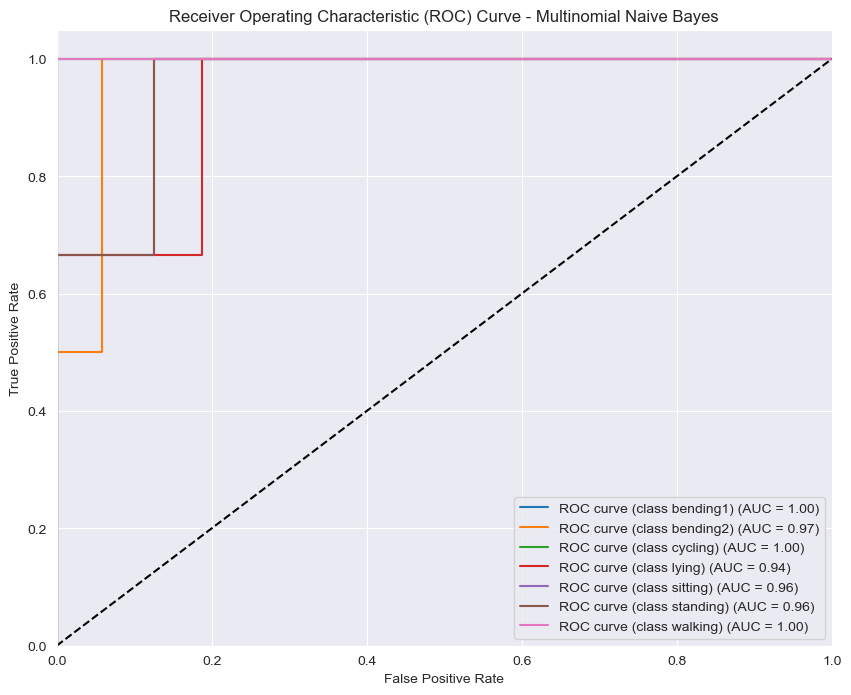

In [199]:
# Repeat Confusion Matrix and ROC Curve for Multinomial NB
# Confusion Matrix for Multinomial NB
cm_multinomial = confusion_matrix(y_test_encoded_multinomial, multinomial_model.predict(X_test_scaled_multinomial))
plt.figure(figsize=(10, 8))
sns.heatmap(cm_multinomial, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_multinomial.classes_, yticklabels=le_multinomial.classes_)
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for Multinomial NB
y_test_proba_multinomial = multinomial_model.predict_proba(X_test_scaled_multinomial)
n_classes_multinomial = len(le_multinomial.classes_)

fpr_multinomial = dict()
tpr_multinomial = dict()
roc_auc_multinomial = dict()

for i in range(n_classes_multinomial):
    fpr_multinomial[i], tpr_multinomial[i], _ = roc_curve(y_test_encoded_multinomial == i, y_test_proba_multinomial[:, i])
    roc_auc_multinomial[i] = auc(fpr_multinomial[i], tpr_multinomial[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes_multinomial):
    plt.plot(fpr_multinomial[i], tpr_multinomial[i], label=f'ROC curve (class {le_multinomial.classes_[i]}) (AUC = {roc_auc_multinomial[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()

#### iii. Which method is better for multi-class classification in this problem?Observations:

Both methods perform equally well for bending1, cycling, standing, and walking classes (perfect or near-perfect classification).
1. Gaussian Naive Bayes performs better for the bending2 class (1.00 vs 0.97).
2. Multinomial Naive Bayes performs significantly better for the lying class (0.94 vs 0.80).
3. Multinomial Naive Bayes performs slightly better for the sitting class (0.96 vs 0.95).

The Multinomial Naive Bayes classifier appears to be the better method for this multi-class classification problem. While both methods perform similarly for most classes, the Multinomial Naive Bayes shows more consistent performance across all classes.

### ISLR 4.8.3

### ISLR 4.8.7

In [79]:
# https://www.perplexity.ai/search/this-problem-relates-to-the-qd-9x5AvLG3SdmZo9JY8HeTfg